In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
import collections

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, r2_score, roc_curve, auc, explained_variance_score, mean_squared_error
from sklearn.base import clone 
%matplotlib inline


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df_for_regressions = pd.read_csv('regression_file_wo_interactions.csv')
df_for_regressions.drop(['Unnamed: 0', 'Year'], axis =1 , inplace = True)

In [3]:
df_for_regressions = pd.read_csv('regression_ready_df.csv')
df_for_regressions.drop(['Unnamed: 0'], axis =1 , inplace = True)

In [5]:
df_for_regressions.drop(['award_sum', 'company_count', 'creative_employees', 'creative_establishments',
                        'performance_amount', 'performance_count', 'recipient_amount', 'recipient_count',
                        'regular_employees', 'regular_establishments', 'percent_creative_class'], axis = 1,
                       inplace = True)

In [6]:
df_for_regressions = df_for_regressions.loc[df_for_regressions.Year == 2012]

In [7]:
df_for_regressions.head()

,award_mean,Year,Score_invented,Score_assigned,scaled_perc_creative_class,creative_establishment_ratio,company_count_perc,recipient_mean,performance_mean,city_state,empowerment_zone
8069,0.941381,2012,2.921344,3.861635,0.889998,0.742632,0.667825,0.902842,0.970240,mountainview_ca,0
8070,0.990433,2012,2.283595,3.594052,1.562141,0.540220,-0.226459,1.102752,1.139275,houston_tx,1
8071,0.915021,2012,2.419212,3.609109,1.110383,1.016642,0.331379,0.908560,0.988551,santaclara_ca,0
8072,0.957517,2012,3.257758,4.274022,1.148971,0.340488,-0.171831,0.816917,0.855317,sanjose_ca,0
8073,0.838104,2012,3.257758,4.274022,1.148971,0.340488,-0.279902,0.816917,0.855317,sanjose_ca,0


# Run Regressions

## Run Random Forest Regression

In [19]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(4,15),
            'n_estimators': (25, 50, 100, 200, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_


    return(best_params)

In [20]:
def run_rfr(score, temp_df):
    y = temp_df[score]

    x = temp_df.drop(['Score_assigned', 'Score_invented','city_state', 'Year'], axis = 1)
    features = {}
    R_IS_list = []
    R_OS_list = []
    EV_IS_list = []
    EV_OS_list = []
    mean_sq_err_list = []
    for k in range(1,11):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = k)
        x_valid, x_valid_test, y_valid, y_valid_test = train_test_split(x_train, y_train, test_size = 0.33, 
                                                                        random_state = k)
        params = rfr_model(x_valid,y_valid)
        regressor = RandomForestRegressor(max_depth=params['max_depth'], n_estimators=params['n_estimators'])
        regressor.fit(x_train, y_train)

        importances = regressor.feature_importances_
        indices = np.argsort(importances)[::-1]

        
        for i in indices:
            try:
                features[x.columns[i]] = features[x.columns[i]] + regressor.feature_importances_[i]
            except:
                features[x.columns[i]] = regressor.feature_importances_[i]
        
        y_pred1 = regressor.predict(x_train)
        y_pred2 = regressor.predict(x_test)
        R_IS_list.append(1-((np.asarray(y_pred1)-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())
        R_OS_list.append(1-((np.asarray(y_pred2)-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
        EV_IS_list.append(explained_variance_score(y_train, y_pred1, multioutput='variance_weighted'))
        EV_OS_list.append(explained_variance_score(y_test, y_pred2, multioutput='variance_weighted'))
        mean_sq_err_list.append(mean_squared_error(y_test, y_pred2))
    
    for key in features:
        features[key] = features[key] / 10
    
    title = 'Feature Importance for ' + str(score)
        
    lists = sorted(features.items(), key = lambda item: item[1], reverse = True) # sorted by key, return a list of tuples
    x_chart, y_chart = zip(*lists) # unpack a list of pairs into two tuples
    plt.figure(figsize=(8,8))
    plt.bar(x_chart, y_chart)
    plt.title(title, fontsize = 20)
    plt.ylabel("Importance", fontsize = 15)
    plt.xlabel("Feature", fontsize = 15)
    plt.xticks(rotation = 'vertical')
    plt.show()
    

    R_IS = statistics.mean(R_IS_list)
    print("The In-sample R-squared for RFR is: {0}".format(R_IS))
    EV_IS = statistics.mean(EV_IS_list)
    print("The In-sample Explained Variance is: {0}".format(EV_IS))
    print(' ')
    
    R_OS = statistics.mean(R_OS_list)
    print("The Out-of-sample R-squared for RFR: {0}".format(R_OS))
    
    EV_OS = statistics.mean(EV_OS_list)
    print("The Out-of-sample Explained Variance is: {0}".format(EV_OS))
    
    mean_sq = statistics.mean(mean_sq_err_list)
    print("The Out-of-sample mean squared error is: {0}".format(mean_sq))
    


In [21]:
def new_rfr(score, temp_df, split):
    score_75_perc = temp_df[score].describe()[-2]
    
    if split == 'top':
        temp_df = temp_df.loc[temp_df[score] > score_75_perc]
        
    elif split == 'bottom':
        temp_df = temp_df.loc[temp_df[score] < score_75_perc]
    
        
    y = temp_df[score]
    x = temp_df.drop(['Score_assigned', 'Score_invented','city_state', 'Year'], axis = 1)

    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 1)
    x_valid, x_valid_test, y_valid, y_valid_test = train_test_split(x_train, y_train, test_size = 0.33, 
                                                                        random_state = 1)
    params = rfr_model(x_valid,y_valid)
    regressor = RandomForestRegressor(max_depth=params['max_depth'], n_estimators=params['n_estimators'],
                                     random_state = 1)
    regressor.fit(x_train, y_train)
    benchmark_score = regressor.score(x_train, y_train)
    
    importances = {}
    
    for col in x_train.columns:
        model = clone(regressor)
        model.random_state = 1
        model.fit(x_train.drop(col, axis = 1), y_train)
        drop_col_score = model.score(x_train.drop(col, axis = 1), y_train)
        importances[col] = benchmark_score - drop_col_score
    
    title = 'Change in Model Score for ' + str(split) + ' Innovative Cities for '+ str(score)
        
    lists = sorted(importances.items(), key = lambda item: item[1], reverse = True) # sorted by key, return a list of tuples
    x_chart, y_chart = zip(*lists) # unpack a list of pairs into two tuples
    plt.figure(figsize=(8,8))
    plt.bar(x_chart, y_chart)
    plt.title(title, fontsize = 20)
    plt.ylabel("Importance", fontsize = 15)
    plt.xlabel("Feature", fontsize = 15)
    plt.xticks(rotation = 'vertical')
    plt.show()
    

### Testing Score invented

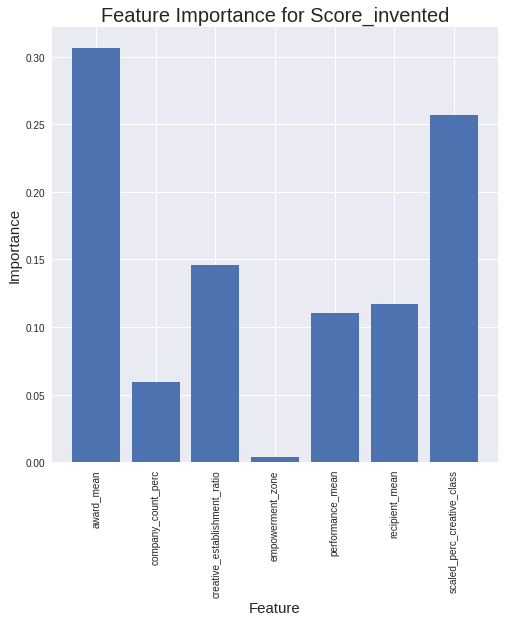

The In-sample R-squared for RFR is: 0.4577148518837765
The In-sample Explained Variance is: 0.45772941123932076
 
The Out-of-sample R-squared for RFR: 0.23656132877134906
The Out-of-sample Explained Variance is: 0.24217405537247094
The Out-of-sample mean squared error is: 0.7281126351250976


In [22]:
run_rfr('Score_invented', df_for_regressions)

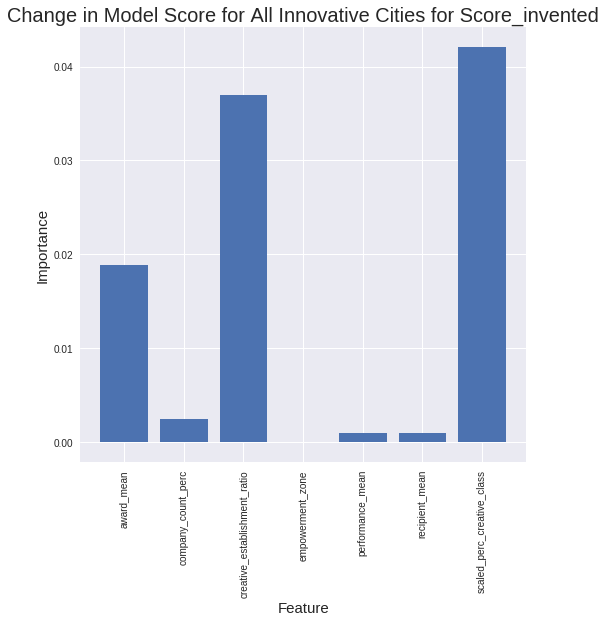

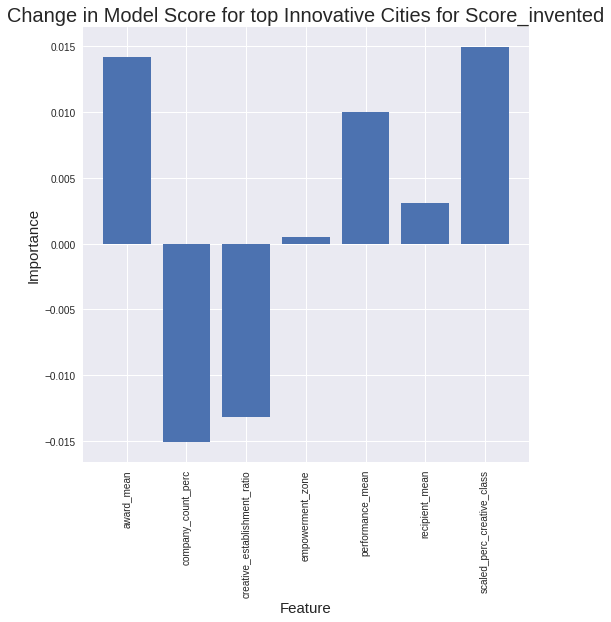

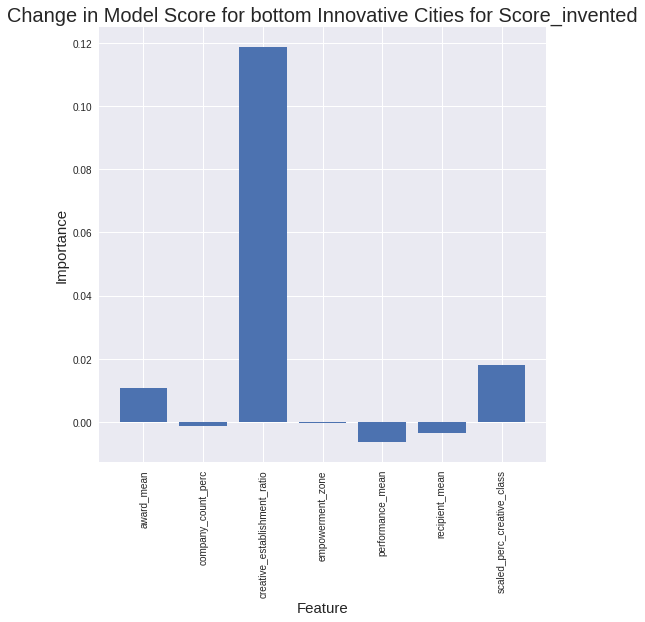

In [23]:
new_rfr('Score_invented', df_for_regressions, 'All')
new_rfr('Score_invented', df_for_regressions, 'top')
new_rfr('Score_invented', df_for_regressions, 'bottom')

### Score assigned

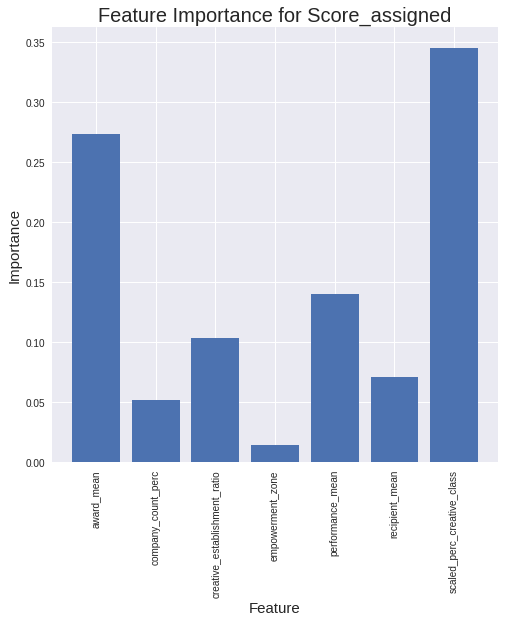

The In-sample R-squared for RFR is: 0.5723533423593058
The In-sample Explained Variance is: 0.572365150197034
 
The Out-of-sample R-squared for RFR: 0.28491157878799483
The Out-of-sample Explained Variance is: 0.29066178287463573
The Out-of-sample mean squared error is: 0.6652831063568002


In [24]:
try:
    run_rfr('Score_assigned', df_for_regressions)
except:
    print('error')

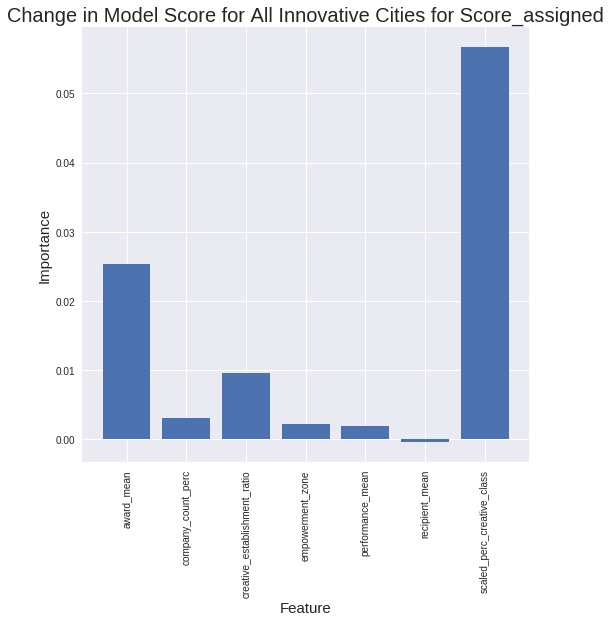

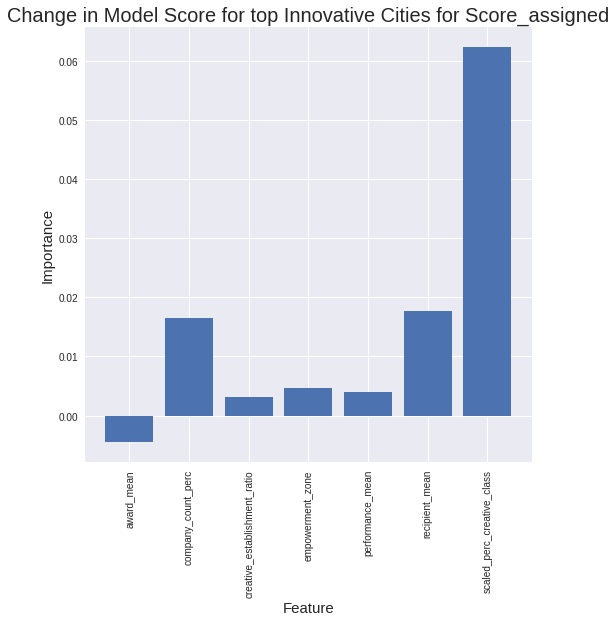

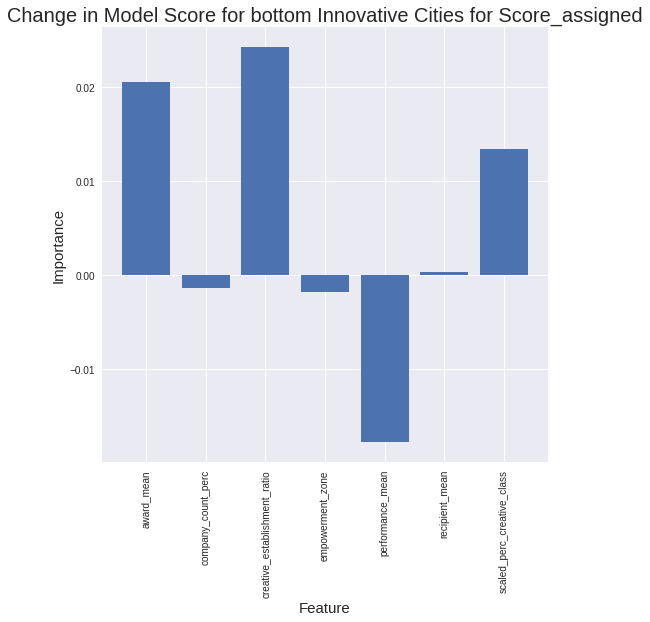

In [25]:
try:
    new_rfr('Score_assigned', df_for_regressions, 'All')
    new_rfr('Score_assigned', df_for_regressions, 'top')
    new_rfr('Score_assigned', df_for_regressions, 'bottom')
except:
    print('error')

## Run Logistic Regression

In [26]:
def logistic_reg(score, df):
    score_75_perc = df[score].describe()[-2]
    y = df[score].apply(lambda x: 1 if x > score_75_perc else 0)
    
    #top 25% cities
    df_top_25 = df.loc[df[score] > score_75_perc]
    df_bottom = df.loc[df[score] < score_75_perc]
    


    print(y.value_counts())
    y = y.fillna(0)
    print(" ")
    

    X = df.drop(['Score_assigned', 'Score_invented','city_state', 'Year'], axis = 1)
    
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)
    
    #Simple Logistic Score
    clf = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial')
    clf.fit(x_train, y_train)
    print("Regression score: " + str(clf.score(x_test, y_test)))
    print(' ')
    
    #Model Accuracy
    kfold = KFold(n_splits=10, random_state=0)
    model = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial')
    scoring = 'accuracy'
    results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print("Model Accuracy Results: " + str(results.mean()))
    print(' ')
          
    #Log Loss
    try:
        scoring = 'neg_log_loss'
        results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        print("Log Loss Results: " + str(results.mean()))
        print(' ')
    except:
        print("Error in Log Loss Function")
          
    
    #AUC
    try:
        scoring = 'roc_auc'
        results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        print("Area Under Curve: " + str(results.mean()))
        print(' ')
        
        model_importance = {}
        for col in X.columns:
            cloned_model = clone(model)
            cloned_model.random_state = 1
            drop_col_score = cross_val_score(cloned_model, (X.drop(col, axis = 1)), y, cv=kfold, scoring=scoring)
            model_importance[col] = results.mean() - drop_col_score.mean()
            
        title = 'Change in AUC After Dropping Each Feature'
        
        lists = sorted(model_importance.items(), key = lambda item: item[1], reverse = True) # sorted by key, return a list of tuples
        x_chart, y_chart = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(figsize=(8,8))
        plt.bar(x_chart, y_chart)
        plt.title(title, fontsize = 20)
        plt.ylabel("Change in AUC", fontsize = 15)
        plt.xlabel("Feature", fontsize = 15)
        plt.xticks(rotation = 'vertical')
        plt.show()
        
    except:
        print("Error in AUC Function")
    
          
    #Confusion Matrix
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    matrix = confusion_matrix(y_test, predicted)
    print("Confusion Matrix: ")
    print(matrix)
    print(' ')
          
    #Classification report
    report = classification_report(y_test, predicted)
    print("Classification Report: ")
    print(report)
    
    
    features = {}
    
    #Feature Importance
    coefficients = list(clf.coef_)
    for i in range(len(X.columns)):
        features[X.columns[i]] = [coefficients[0][i]]
    
    print(' ')
    print(' ')
        
    #Feature Importance for top 25 only
    score_75_perc = df_top_25[score].describe()[-2]
    y = df_top_25[score].apply(lambda x: 1 if x > score_75_perc else 0)
    X = df_top_25.drop(['Score_assigned', 'Score_invented','city_state', 'Year'], axis = 1)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)
    clf = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial')
    clf.fit(x_train, y_train)
    coefficients = list(clf.coef_)
    for i in range(len(X.columns)):
        features[X.columns[i]].append(coefficients[0][i])  
    
    print("AUC for Top 25%")
    try:
        scoring = 'roc_auc'
        results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        print("AUC Results: " + str(results.mean()))
        print(' ')
    except:
        print("Error in AUC Function")
    
    
    print(' ')
    print(' ')
        
    #Feature Importance for bottom 75
    score_75_perc = df_bottom[score].describe()[-2]
    y = df_bottom[score].apply(lambda x: 1 if x > score_75_perc else 0)
    X = df_bottom.drop(['Score_assigned', 'Score_invented','city_state', 'Year'], axis = 1)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)
    clf = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial')
    clf.fit(x_train, y_train)
    coefficients = list(clf.coef_)
    for i in range(len(X.columns)):
        features[X.columns[i]].append(coefficients[0][i])

        
    print("AUC for Bottom 75%")
    try:
        scoring = 'roc_auc'
        results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        print("AUC Results: " + str(results.mean()))
        print(' ')
    except:
        print("Error in AUC Function")
        

    #Plot pivot table
    features = (pd.DataFrame.from_dict(features, orient = 'index', columns=['Total', 'Top 25%', 'Bottom 75%']))
    features.reset_index(inplace = True)
    title = str(score) + ": Feature Importance for all Cities, Top 25%, and Bottom 75%"
    pd.pivot_table(features,index=["index"]).plot(kind = 'bar', figsize = (12,12), 
                                                  title = title)
    

In [27]:
df_for_logistic = df_for_regressions.copy(deep = True)

### Score Invented

0    596
1    199
Name: Score_invented, dtype: int64
 
Regression score: 0.7376425855513308
 
Model Accuracy Results: 0.728101265822785
 
Log Loss Results: -0.5756726986537308
 
Area Under Curve: 0.5845447184975633
 


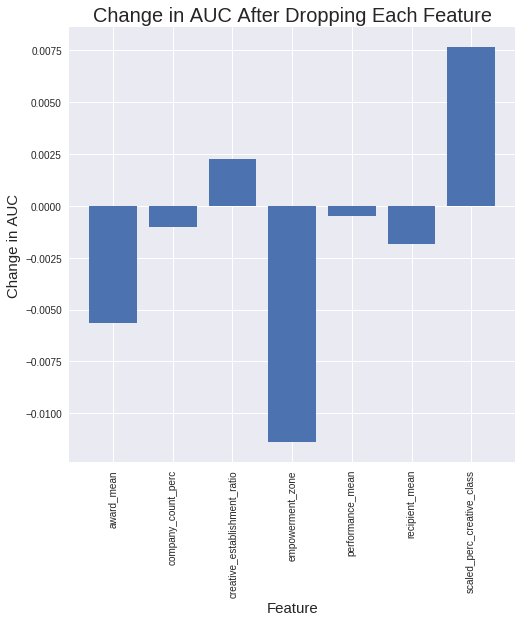

Confusion Matrix: 
[[187   9]
 [ 60   7]]
 
Classification Report: 
             precision    recall  f1-score   support

          0       0.76      0.95      0.84       196
          1       0.44      0.10      0.17        67

avg / total       0.68      0.74      0.67       263

 
 
AUC for Top 25%
Error in AUC Function
 
 
AUC for Bottom 75%
AUC Results: 0.6057684881873102
 


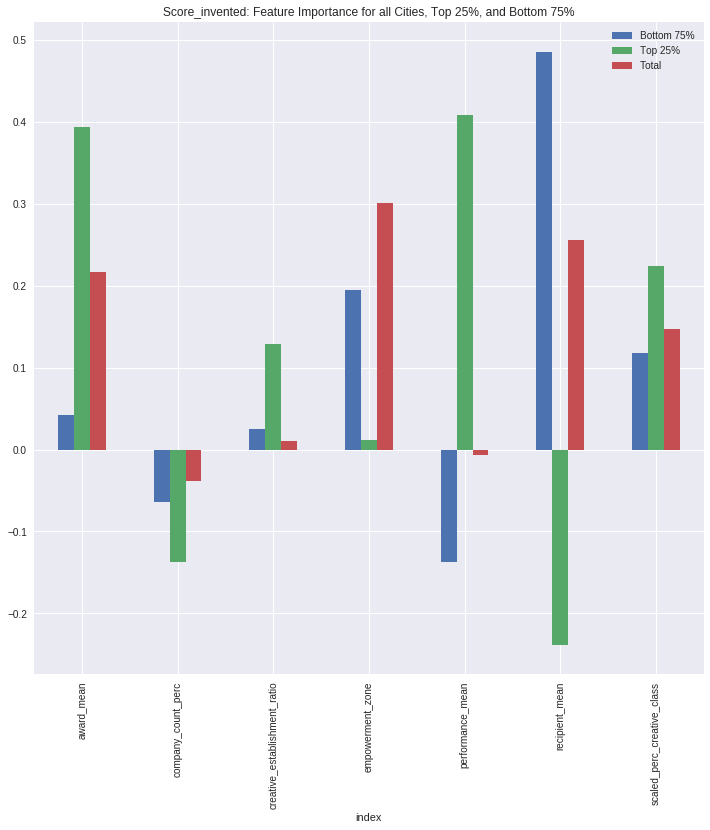

In [28]:
logistic_reg('Score_invented', df_for_logistic)

### Score Assigned

0    596
1    199
Name: Score_assigned, dtype: int64
 
Regression score: 0.7718631178707225
 
Model Accuracy Results: 0.7322468354430379
 
Error in Log Loss Function
Error in AUC Function
Confusion Matrix: 
[[182  12]
 [ 48  21]]
 
Classification Report: 
             precision    recall  f1-score   support

          0       0.79      0.94      0.86       194
          1       0.64      0.30      0.41        69

avg / total       0.75      0.77      0.74       263

 
 
AUC for Top 25%
Error in AUC Function
 
 
AUC for Bottom 75%
AUC Results: 0.5709410921856133
 


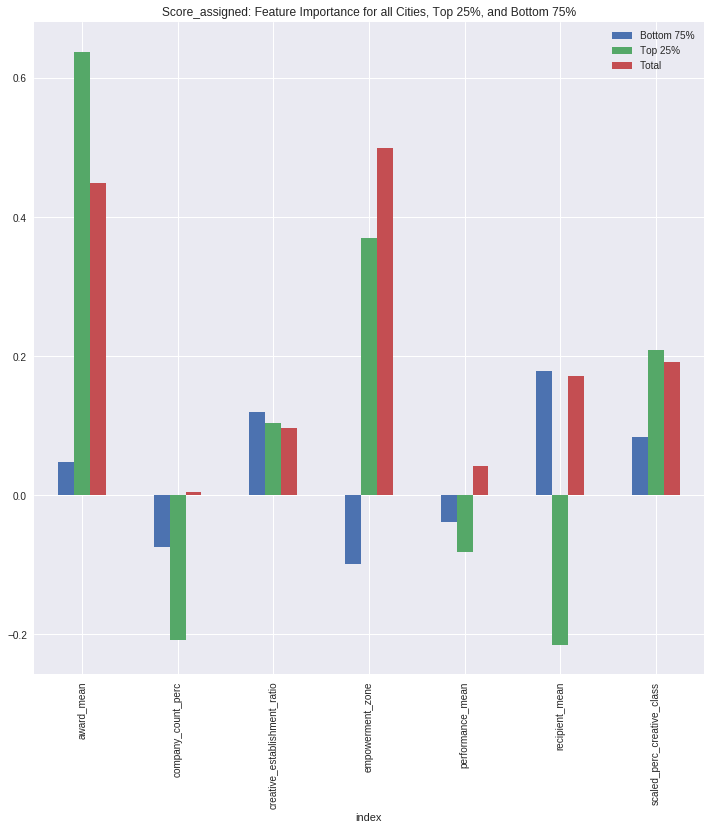

In [29]:
logistic_reg('Score_assigned', df_for_logistic)